In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, CuDNNLSTM, CuDNNGRU, BatchNormalization, LocallyConnected2D, Permute, TimeDistributed, Bidirectional
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
from keras.utils.generic_utils import Progbar
from keras.layers.merge import _Merge
import keras.losses
from keras.datasets import mnist

from functools import partial

from collections import defaultdict

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import os
import pickle
import numpy as np

import isolearn.io as isoio
import isolearn.keras as isol

import pandas as pd

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

from sequence_logo_helper import dna_letter_at, plot_dna_logo

from keras.backend.tensorflow_backend import set_session

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()

class EpochVariableCallback(Callback) :
    
    def __init__(self, my_variable, my_func) :
        self.my_variable = my_variable       
        self.my_func = my_func
        
    def on_epoch_begin(self, epoch, logs={}) :
        K.set_value(self.my_variable, self.my_func(K.get_value(self.my_variable), epoch))


Using TensorFlow backend.


In [2]:
#Define dataset/experiment name
dataset_name = "optimus5_synthetic_if_uorf_1_start_2_stop_variable_loc"

def one_hot_encode(df, col='utr', seq_len=50):
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0]}
    
    # Creat empty matrix.
    vectors=np.empty([len(df),seq_len,4])
    
    # Iterate through UTRs and one-hot encode
    for i,seq in enumerate(df[col].str[:seq_len]): 
        seq = seq.lower()
        a = np.array([nuc_d[x] for x in seq])
        vectors[i] = a
    return vectors

def one_hot_encode_gt(df, col='gt', seq_len=50):
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'n':[1,0,0,0,0,0,0],'a':[0,1,0,0,0,0,0],'b':[0,0,1,0,0,0,0],'c':[0,0,0,1,0,0,0],'x':[0,0,0,0,1,0,0],'y':[0,0,0,0,0,1,0],'z':[0,0,0,0,0,0,1]}
    
    # Creat empty matrix.
    vectors=np.empty([len(df),seq_len,7])
    
    # Iterate through UTRs and one-hot encode
    for i,seq in enumerate(df[col].str[:seq_len]): 
        seq = seq.lower()
        a = np.array([nuc_d[x] for x in seq])
        vectors[i] = a
    return vectors

#Train data
df_train = pd.read_csv("bottom5KIFuAUGTop5KIFuAUG.csv")
x_train = np.expand_dims(one_hot_encode(df_train), axis=1)

#Test data
df_test = pd.read_csv("optimus5_synthetic_if_uorf_1_start_2_stop_variable_loc.csv")
x_test = np.expand_dims(one_hot_encode(df_test), axis=1)
y_test = one_hot_encode_gt(df_test)

print("x_train.shape = " + str(x_train.shape))
print("x_test.shape = " + str(x_test.shape))
print("y_test.shape = " + str(y_test.shape))


x_train.shape = (15008, 1, 50, 4)
x_test.shape = (512, 1, 50, 4)
y_test.shape = (512, 50, 7)


In [3]:
#Define sequence template (APA Doubledope sublibrary)

sequence_template = 'N' * 50

sequence_mask = np.array([1 if sequence_template[j] == 'N' else 0 for j in range(len(sequence_template))])


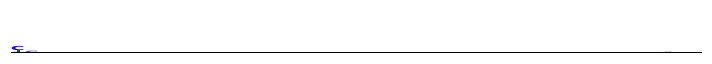

In [4]:
#Visualize background sequence distribution

save_figs = False

pseudo_count = 1.0

x_mean = (np.sum(x_train, axis=(0, 1)) + pseudo_count) / (x_train.shape[0] + 4. * pseudo_count)
x_mean_logits = np.log(x_mean / (1. - x_mean))

plot_dna_logo(np.copy(x_mean), sequence_template=sequence_template, figsize=(10, 1), logo_height=1.0, plot_start=0, plot_end=50, plot_sequence_template=True, save_figs=save_figs, fig_name="benchmark_inclusion_" + dataset_name + "_background")


In [5]:
#Calculate mean training set conservation

entropy = np.sum(x_mean * -np.log(x_mean), axis=-1) / np.log(2.0)
conservation = 2.0 - entropy

x_mean_conservation = np.sum(conservation) / np.sum(sequence_mask)

print("Mean conservation (bits) = " + str(x_mean_conservation))


Mean conservation (bits) = 0.032049298346210106


In [6]:
#Calculate mean training set kl-divergence against background

x_train_clipped = np.clip(np.copy(x_train[:, 0, :, :]), 1e-8, 1. - 1e-8)

kl_divs = np.sum(x_train_clipped * np.log(x_train_clipped / np.tile(np.expand_dims(x_mean, axis=0), (x_train_clipped.shape[0], 1, 1))), axis=-1) / np.log(2.0)

x_mean_kl_divs = np.sum(kl_divs * sequence_mask, axis=-1) / np.sum(sequence_mask)
x_mean_kl_div = np.mean(x_mean_kl_divs)

print("Mean KL Div against background (bits) = " + str(x_mean_kl_div))


Mean KL Div against background (bits) = 1.9679329305814974


In [7]:
from tensorflow.python.framework import ops

#Stochastic Binarized Neuron helper functions (Tensorflow)
#ST Estimator code adopted from https://r2rt.com/beyond-binary-ternary-and-one-hot-neurons.html
#See Github https://github.com/spitis/

def st_sampled_softmax(logits):
    with ops.name_scope("STSampledSoftmax") as namescope :
        nt_probs = tf.nn.softmax(logits)
        onehot_dim = logits.get_shape().as_list()[1]
        sampled_onehot = tf.one_hot(tf.squeeze(tf.multinomial(logits, 1), 1), onehot_dim, 1.0, 0.0)
        with tf.get_default_graph().gradient_override_map({'Ceil': 'Identity', 'Mul': 'STMul'}):
            return tf.ceil(sampled_onehot * nt_probs)

def st_hardmax_softmax(logits):
    with ops.name_scope("STHardmaxSoftmax") as namescope :
        nt_probs = tf.nn.softmax(logits)
        onehot_dim = logits.get_shape().as_list()[1]
        sampled_onehot = tf.one_hot(tf.argmax(nt_probs, 1), onehot_dim, 1.0, 0.0)
        with tf.get_default_graph().gradient_override_map({'Ceil': 'Identity', 'Mul': 'STMul'}):
            return tf.ceil(sampled_onehot * nt_probs)

@ops.RegisterGradient("STMul")
def st_mul(op, grad):
    return [grad, grad]

#Gumbel Distribution Sampler
def gumbel_softmax(logits, temperature=0.5) :
    gumbel_dist = tf.contrib.distributions.RelaxedOneHotCategorical(temperature, logits=logits)
    batch_dim = logits.get_shape().as_list()[0]
    onehot_dim = logits.get_shape().as_list()[1]
    return gumbel_dist.sample()


In [8]:
#PWM Masking and Sampling helper functions

def mask_pwm(inputs) :
    pwm, onehot_template, onehot_mask = inputs

    return pwm * onehot_mask + onehot_template

def sample_pwm_st(pwm_logits) :
    n_sequences = K.shape(pwm_logits)[0]
    seq_length = K.shape(pwm_logits)[2]

    flat_pwm = K.reshape(pwm_logits, (n_sequences * seq_length, 4))
    sampled_pwm = st_sampled_softmax(flat_pwm)

    return K.reshape(sampled_pwm, (n_sequences, 1, seq_length, 4))

def sample_pwm_gumbel(pwm_logits) :
    n_sequences = K.shape(pwm_logits)[0]
    seq_length = K.shape(pwm_logits)[2]

    flat_pwm = K.reshape(pwm_logits, (n_sequences * seq_length, 4))
    sampled_pwm = gumbel_softmax(flat_pwm, temperature=0.5)

    return K.reshape(sampled_pwm, (n_sequences, 1, seq_length, 4))

#Generator helper functions
def initialize_sequence_templates(generator, sequence_templates, background_matrices) :

    embedding_templates = []
    embedding_masks = []
    embedding_backgrounds = []

    for k in range(len(sequence_templates)) :
        sequence_template = sequence_templates[k]
        onehot_template = iso.OneHotEncoder(seq_length=len(sequence_template))(sequence_template).reshape((1, len(sequence_template), 4))

        for j in range(len(sequence_template)) :
            if sequence_template[j] not in ['N', 'X'] :
                nt_ix = np.argmax(onehot_template[0, j, :])
                onehot_template[:, j, :] = -4.0
                onehot_template[:, j, nt_ix] = 10.0
            elif sequence_template[j] == 'X' :
                onehot_template[:, j, :] = -1.0

        onehot_mask = np.zeros((1, len(sequence_template), 4))
        for j in range(len(sequence_template)) :
            if sequence_template[j] == 'N' :
                onehot_mask[:, j, :] = 1.0

        embedding_templates.append(onehot_template.reshape(1, -1))
        embedding_masks.append(onehot_mask.reshape(1, -1))
        embedding_backgrounds.append(background_matrices[k].reshape(1, -1))

    embedding_templates = np.concatenate(embedding_templates, axis=0)
    embedding_masks = np.concatenate(embedding_masks, axis=0)
    embedding_backgrounds = np.concatenate(embedding_backgrounds, axis=0)

    generator.get_layer('template_dense').set_weights([embedding_templates])
    generator.get_layer('template_dense').trainable = False

    generator.get_layer('mask_dense').set_weights([embedding_masks])
    generator.get_layer('mask_dense').trainable = False
    
    generator.get_layer('background_dense').set_weights([embedding_backgrounds])
    generator.get_layer('background_dense').trainable = False

#Generator construction function
def build_sampler(batch_size, seq_length, n_classes=1, n_samples=1, sample_mode='st') :

    #Initialize Reshape layer
    reshape_layer = Reshape((1, seq_length, 4))
    
    #Initialize background matrix
    onehot_background_dense = Embedding(n_classes, seq_length * 4, embeddings_initializer='zeros', name='background_dense')

    #Initialize template and mask matrices
    onehot_template_dense = Embedding(n_classes, seq_length * 4, embeddings_initializer='zeros', name='template_dense')
    onehot_mask_dense = Embedding(n_classes, seq_length * 4, embeddings_initializer='ones', name='mask_dense')

    #Initialize Templating and Masking Lambda layer
    masking_layer = Lambda(mask_pwm, output_shape = (1, seq_length, 4), name='masking_layer')
    background_layer = Lambda(lambda x: x[0] + x[1], name='background_layer')
    
    #Initialize PWM normalization layer
    pwm_layer = Softmax(axis=-1, name='pwm')
    
    #Initialize sampling layers
    sample_func = None
    if sample_mode == 'st' :
        sample_func = sample_pwm_st
    elif sample_mode == 'gumbel' :
        sample_func = sample_pwm_gumbel
    
    upsampling_layer = Lambda(lambda x: K.tile(x, [n_samples, 1, 1, 1]), name='upsampling_layer')
    sampling_layer = Lambda(sample_func, name='pwm_sampler')
    permute_layer = Lambda(lambda x: K.permute_dimensions(K.reshape(x, (n_samples, batch_size, 1, seq_length, 4)), (1, 0, 2, 3, 4)), name='permute_layer')
    
    def _sampler_func(class_input, raw_logits) :
        
        #Get Template and Mask
        onehot_background = reshape_layer(onehot_background_dense(class_input))
        onehot_template = reshape_layer(onehot_template_dense(class_input))
        onehot_mask = reshape_layer(onehot_mask_dense(class_input))
        
        #Add Template and Multiply Mask
        pwm_logits = masking_layer([background_layer([raw_logits, onehot_background]), onehot_template, onehot_mask])
        
        #Compute PWM (Nucleotide-wise Softmax)
        pwm = pwm_layer(pwm_logits)
        
        #Tile each PWM to sample from and create sample axis
        pwm_logits_upsampled = upsampling_layer(pwm_logits)
        sampled_pwm = sampling_layer(pwm_logits_upsampled)
        sampled_pwm = permute_layer(sampled_pwm)

        sampled_mask = permute_layer(upsampling_layer(onehot_mask))
        
        return pwm_logits, pwm, sampled_pwm, onehot_mask, sampled_mask
    
    return _sampler_func


In [9]:
#Initialize Encoder and Decoder networks
batch_size = 32
seq_length = 50
n_samples = 128
sample_mode = 'st'
#sample_mode = 'gumbel'

#Load sampler
sampler = build_sampler(batch_size, seq_length, n_classes=1, n_samples=n_samples, sample_mode=sample_mode)


In [10]:
#Load Predictor
predictor_path = 'optimusRetrainedMain.hdf5'

predictor_temp = load_model(predictor_path)

predictor_temp.trainable = False
predictor_temp.compile(optimizer=keras.optimizers.SGD(lr=0.1), loss='mean_squared_error')

predictor_temp.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 50, 120)           3960      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 50, 120)           115320    
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 120)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 50, 120)           115320    
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 120)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                240040    
__________

In [11]:
#Optimus5 parameters
seq_input_shape = (1, 50, 4)

#Inputs
seq_input = Input(shape=seq_input_shape)

permute_layer = Lambda(lambda x: x[:, 0, ...])

predictor = Model(
    inputs=seq_input,
    outputs=[
        predictor_temp([permute_layer(seq_input)])
    ]
)

predictor.trainable = False

predictor.compile(
    optimizer=keras.optimizers.SGD(lr=0.1),
    loss='mean_squared_error'
)


In [12]:
#Build scrambler model
dummy_class = Input(shape=(1,), name='dummy_class')
input_logits = Input(shape=(1, seq_length, 4), name='input_logits')

pwm_logits, pwm, sampled_pwm, pwm_mask, sampled_mask = sampler(dummy_class, input_logits)

scrambler_model = Model([input_logits, dummy_class], [pwm_logits, pwm, sampled_pwm, pwm_mask, sampled_mask])

#Initialize Sequence Templates and Masks
initialize_sequence_templates(scrambler_model, [sequence_template], [x_mean_logits])

scrambler_model.trainable = False
scrambler_model.compile(
    optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
    loss='mean_squared_error'
)


In [13]:
scrambler_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dummy_class (InputLayer)        (None, 1)            0                                            
__________________________________________________________________________________________________
background_dense (Embedding)    (None, 1, 200)       200         dummy_class[0][0]                
__________________________________________________________________________________________________
input_logits (InputLayer)       (None, 1, 50, 4)     0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 1, 50, 4)     0           background_dense[0][0]           
                                                                 template_dense[0][0]             
          

In [14]:

file_names = [
    "scrambler_optimus5_synthetic_if_uorf_1_start_2_stop_variable_loc_importance_scores_test.npy",
    "perturbation_optimus5_synthetic_if_uorf_1_start_2_stop_variable_loc_importance_scores_test.npy"
]

model_names =[
    "scrambler",
    "perturbation"
]

model_importance_scores_test = [np.load(file_name) for file_name in file_names]

for model_i in range(len(model_names)) :
    if model_importance_scores_test[model_i].shape[-1] > 1 :
        model_importance_scores_test[model_i] = np.sum(model_importance_scores_test[model_i], axis=-1, keepdims=True)


In [15]:

feature_quantiles = [0.76, 0.82, 0.88]

on_state_logit_val = 50.

dummy_test = np.zeros((x_test.shape[0], 1))
x_test_logits = 2. * x_test - 1.

aparent_l_test = np.zeros((x_test.shape[0], 13))
aparent_l_test[:, 4] = 1.

aparent_d_test = np.ones((x_test.shape[0], 1))

y_pred_ref = predictor.predict([x_test], batch_size=32, verbose=True)

_, _, _, pwm_mask, sampled_mask = scrambler_model.predict([x_test_logits, dummy_test], batch_size=batch_size)

model_mses = []

for model_i in range(len(model_names)) :
    
    print("Benchmarking model '" + str(model_names[model_i]) + "'...")
    
    feature_quantile_mses = []
    
    for feature_quantile_i, feature_quantile in enumerate(feature_quantiles) :
        
        print("Feature quantile = " + str(feature_quantile))
    
        if len(model_importance_scores_test[model_i].shape) >= 5 :
            importance_scores_test = np.abs(model_importance_scores_test[model_i][feature_quantile_i, ...])
        else :
            importance_scores_test = np.abs(model_importance_scores_test[model_i])
        
        n_to_test = importance_scores_test.shape[0] // batch_size * batch_size
        importance_scores_test = importance_scores_test[:n_to_test]
        
        importance_scores_test *= np.expand_dims(np.max(pwm_mask[:n_to_test], axis=-1), axis=-1)

        quantile_vals = np.quantile(importance_scores_test, axis=(1, 2, 3), q=feature_quantile, keepdims=True)
        quantile_vals = np.tile(quantile_vals, (1, importance_scores_test.shape[1], importance_scores_test.shape[2], importance_scores_test.shape[3]))

        top_logits_test = np.zeros(importance_scores_test.shape)
        top_logits_test[importance_scores_test > quantile_vals] = on_state_logit_val
        
        top_logits_test = np.tile(top_logits_test, (1, 1, 1, 4)) * x_test_logits[:n_to_test]

        _, _, samples_test, _, _ = scrambler_model.predict([top_logits_test, dummy_test[:n_to_test]], batch_size=batch_size)

        mses = []
        for data_ix in range(samples_test.shape[0]) :

            if data_ix % 100 == 0 :
                print("Processing example " + str(data_ix) + "...")

            y_pred_var_samples = predictor.predict([samples_test[data_ix, ...]], batch_size=n_samples)[:, 0]
            y_pred_ref_samples = np.tile(y_pred_ref[data_ix, :], (n_samples,))
            
            mse = np.mean((y_pred_ref_samples - y_pred_var_samples)**2)

            mses.append(mse)

        mses = np.array(mses)
        
        feature_quantile_mses.append(mses)

    model_mses.append(feature_quantile_mses)


512/512 [==============================] - 1s 2ms/step
Benchmarking model 'scrambler'...
Feature quantile = 0.76
Processing example 0...
Processing example 100...
Processing example 200...
Processing example 300...
Processing example 400...
Processing example 500...
Feature quantile = 0.82
Processing example 0...
Processing example 100...
Processing example 200...
Processing example 300...
Processing example 400...
Processing example 500...
Feature quantile = 0.88
Processing example 0...
Processing example 100...
Processing example 200...
Processing example 300...
Processing example 400...
Processing example 500...
Benchmarking model 'perturbation'...
Feature quantile = 0.76
Processing example 0...
Processing example 100...
Processing example 200...
Processing example 300...
Processing example 400...
Processing example 500...
Feature quantile = 0.82
Processing example 0...
Processing example 100...
Processing example 200...
Processing example 300...
Processing example 400...
Processing

In [16]:
model_names =[
    "scrambler",
    "perturbation"
]

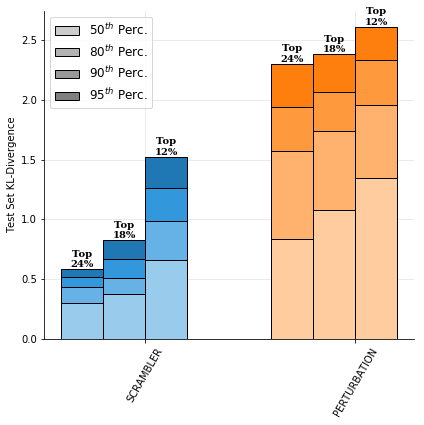

In [17]:
def lighten_color(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

fig = plt.figure(figsize=(6, 6))

benchmark_name = "benchmark_inclusion_optimus5_synthetic_if_uorf_1_start_2_stop_variable_loc"

save_figs = False

width = 0.2

max_y_val = None

cm = plt.get_cmap('viridis_r')

shades = [0.4, 0.6, 0.8, 1]

quantiles = [0.5, 0.8, 0.9, 0.95]

all_colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] + plt.rcParams['axes.prop_cycle'].by_key()['color']
model_colors = {model_names[i]: all_colors[i] for i in range(len(model_names))}

results = np.zeros((len(quantiles), len(model_names), 1))

for i in range(1, len(feature_quantiles) + 1) :
    for j in range(len(model_names)):
        mse_samples = model_mses[j][i-1]

        for l in range(len(quantiles)):
            quantile = quantiles[l]

            results[l, j, 0] = np.quantile(mse_samples, q=quantile)

    xs = range(len(model_names))
    xs = [xi + i*width for xi in xs]
    
    for j in range(len(model_names)) :
        for l in range(len(quantiles)) :
            model_name = model_names[j]
            c = model_colors[model_name]
            val = results[l, j, 0]
            
            if i == 1 and j == 0 :
                lbl = "$%i^{th}$ Perc." % int(100*quantiles[l])
            else :
                lbl=None
            
            if l == 0 :
                plt.bar(xs[j], val, width=width, color=lighten_color(c, shades[l]), edgecolor='k', linewidth=1, label=lbl, zorder=l+1)
            else :
                prev_val = results[l-1, j].mean(axis=-1)
                plt.bar(xs[j],val-prev_val, width=width, bottom = prev_val, color=lighten_color(c, shades[l]), edgecolor='k', linewidth=1, label=lbl, zorder=l+1)
    
            if l == len(quantiles) - 1 and (max_y_val is None or val < 0.95 * max_y_val) :
                plt.text(xs[j], val, "Top\n" + str(int(100 - 100 * feature_quantiles[i-1])) + "%", horizontalalignment='center', verticalalignment='bottom', fontdict={ 'family': 'serif', 'color':  'black', 'weight': 'bold', 'size': 10 })
    
    prev_results = results

plt.xticks([i + 2.5*width for i in range(len(model_names))])

all_lbls = [model_names[j].upper() for j in range(len(model_names))]
plt.gca().set_xticklabels(all_lbls, rotation=60)

plt.ylabel("Test Set KL-Divergence")

#max_y_val = np.max(results) * 1.1

if max_y_val is not None :
    plt.ylim([0, max_y_val])

plt.grid(True)
plt.gca().set_axisbelow(True)
plt.gca().grid(color='gray', alpha=0.2)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.legend(fontsize=12, frameon=True, loc='upper left')
leg = plt.gca().get_legend()
for l in range(len(quantiles)):
    leg.legendHandles[l].set_color(lighten_color(all_colors[7], shades[l]))
    leg.legendHandles[l].set_edgecolor('k')

plt.tight_layout()

if save_figs :
    plt.savefig(benchmark_name + ".png", dpi=300, transparent=True)
    plt.savefig(benchmark_name + ".eps")

plt.show()
